<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/vehicle_speed_estimation/intro.jpg" width=1080px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Vehicle Speed Estimation with YOLOv11 &amp; OpenCV</p>

In [217]:
from collections import defaultdict, deque
from typing import Any

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv
from numpy.typing import ArrayLike, NDArray
from ultralytics import YOLO


<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #004080;
    border-radius: 2px;
    border: 1px solid #004080;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#introduction"><span style="color: #F2F2F0">Introduction</span></a></li>
    <li><a href="#summary"><span style="color: #F2F2F0">Summary</span></a></li>
</ol>
</blockquote>

# <b> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">1</span> <span style='color: #004080'>|</span> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">Introduction</span></b><a class="anchor" id="introduction"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    font-weight: bold;
    color: #4A4B52;
">
    <b><span style="color: #004080; font-weight: bold;">&#x25FC</span>Description</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This notebook explores a practical approach to vehicle speed estimation using computer vision techniques. The video footage we are working with is captured from a CCTV camera overlooking the M6 highway near Knutsford, UK, specifically at $(53.306230, -2.406044)$. This location provides a clear view of vehicles travelling along the highway, offering a real-world scenario for speed detection. The video source is available on YouTube, providing an accessible dataset for this project.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #004080; font-weight: bold;">&#x25FC</span>Steps</b> 
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The goal is to demonstrate a simple yet effective method for estimating vehicle speeds using cutting-edge computer vision technologies. We will use the latest <b>YOLOv11</b> model for object detection and tracking to identify vehicles within the video frames.<br>
    Once vehicles are detected, we will perform a perspective transformation using <b>OpenCV</b> to project points from the camera’s view onto the road plane. This transformation allows us to map vehicle movements more accurately in the real world, compensating for the distortion caused by the camera's viewpoint.<br>
    To enhance the clarity of the results, we will annotate the video using the <b>supervision</b> library, visually marking vehicles and displaying relevant information, such as estimated speeds, directly on the video frames.<br>
    The following steps will be covered:
    <ol style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
        margin-top: 15px;
        margin-bottom: 15px;
        list-style-type: square;
    ">
        <li>Object detection and tracking will be performed using the new <b>YOLOv11</b> model to detect vehicles.</li>
        <li>Perspective transformation and point projection using <b>OpenCV</b> will be applied to map vehicle movement onto the road plane, accounting for the camera's viewpoint distortion.</li>
        <li>Video annotation will be done using the <b>supervision</b> library to display vehicle positions and estimated speeds on the frames.</li>
    </ol>
</p>
<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The main objective is to show how vehicle speed estimation can be achieved in a few simple steps, providing a basic but functional framework that can be expanded for more advanced traffic analysis tasks.
</p>

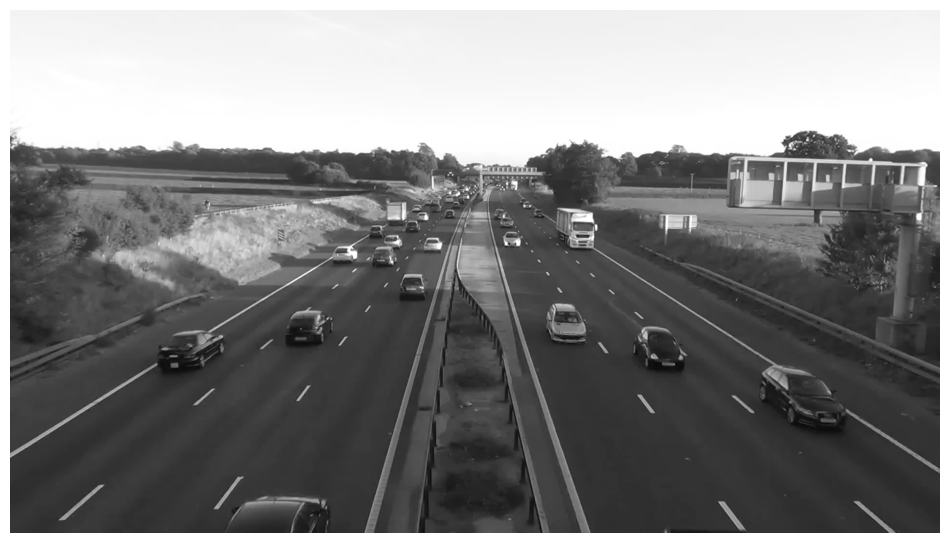

In [220]:
cap = cv.VideoCapture("m6-motorway.mp4")
ret, frame = cap.read()
cap.release()

frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)

plt.figure(figsize=(12, 7))
plt.imshow(frame)
plt.axis("off")
plt.show()

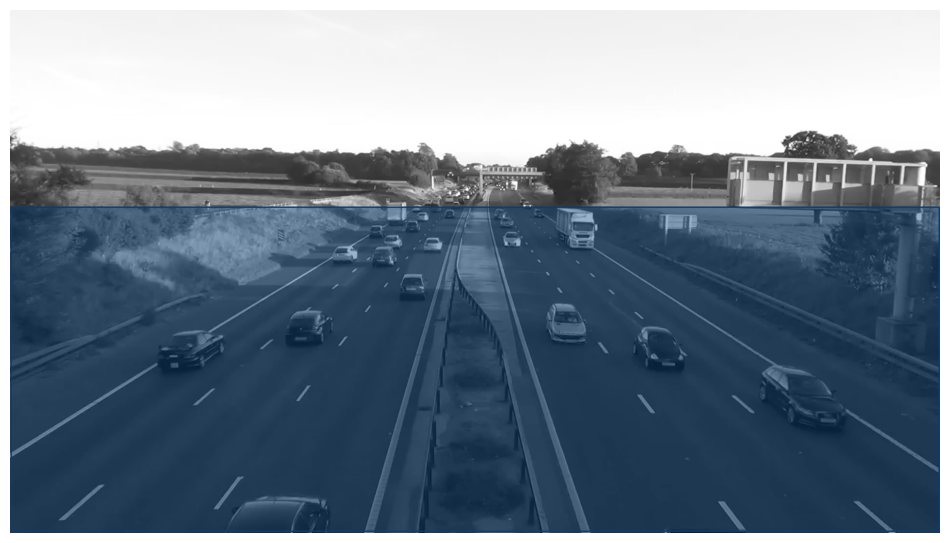

In [224]:
x1, y1, x2, y2 = 0, 410, 1920, 1080

thickness = 2
width = x2 - x1
height = y2 - y1
color = sv.Color.from_hex("#004080")
rect = sv.Rect(x1 + thickness, y1 - thickness, width - 2 * thickness, height - thickness)

rect_frame = frame.copy()
sv.draw_rectangle(rect_frame, rect, color, thickness)
sv.draw_filled_rectangle(rect_frame, rect, color, 0.4)

plt.figure(figsize=(12, 7))
plt.imshow(cv.cvtColor(rect_frame, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

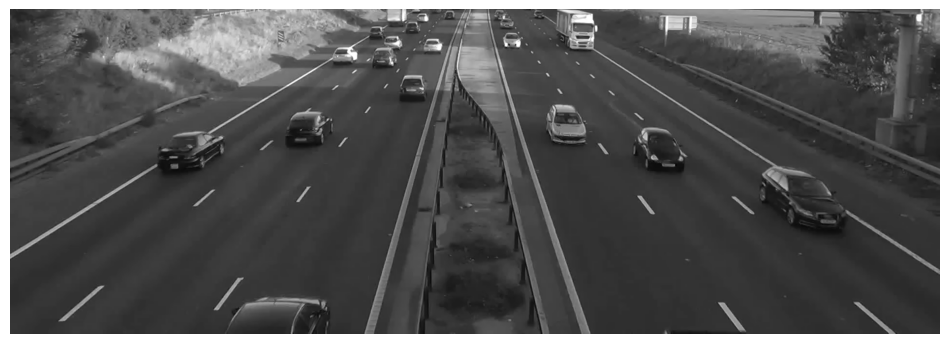

In [225]:
crop = sv.crop_image(frame, (x1, y1, x2, y2))
crop_imgsz = crop.shape[:2]  # height, width

plt.figure(figsize=(12, 6))
plt.imshow(crop)
plt.axis("off")
plt.show()

In [101]:
class PointMarker:
    def __init__(self, window: str = "Image") -> None:
        self._window = window
        self._points: list[tuple[int, int]] = list()

    def __call__(self, image: NDArray) -> list[tuple[int, int]]:
        return self.mark(image)

    @property
    def points(self) -> list[tuple[int, int]]:
        return self._points

    def mark(self, image: NDArray) -> list[tuple[int, int]]:
        image = image.copy()
        cv.namedWindow(self._window, cv.WINDOW_NORMAL)
        cv.setMouseCallback(self._window, self._record_point, param=image)

        while True:
            cv.imshow(self._window, image)
            if cv.waitKey(1) == ord("q"):
                break

        cv.destroyAllWindows()
        return self._points

    def _record_point(self, event: int, x: int, y: int, flags: int, image: Any | None) -> None:
        if event == cv.EVENT_LBUTTONDOWN:
            self._points.append((x, y))
            if image is not None:
                self._draw_point(image, (x, y))

    def _draw_point(self, image: NDArray, point: tuple[int, int]) -> None:
        cv.drawMarker(image, point, (0, 123, 255), cv.MARKER_CROSS, 20, 4, cv.LINE_AA)

In [29]:
marker = PointMarker()
image_pts = marker(crop)

In [8]:
class Cam2WorldMapper:
    def __init__(self) -> None:
        self.M: NDArray | None = None

    def __call__(self, image_pts: ArrayLike) -> NDArray:
        return self.map(image_pts)

    def estimate_perspective_transform(self, image_pts: ArrayLike, world_pts: ArrayLike) -> NDArray:
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts: ArrayLike) -> NDArray:
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)

In [84]:
image_pts = [(810, 0), (1125, 0), (1920, 540), (0, 540)]
world_pts = [(0, 0), (32, 0), (32, 140), (0, 140)]

mapper = Cam2WorldMapper()
mapper.estimate_perspective_transform(image_pts, world_pts)
mapper(image_pts)

array([[ 1.4211e-14,           0],
       [         32,           0],
       [         32,         140],
       [          0,         140]], dtype=float32)

In [219]:
source = "m6-motorway.mp4"
output = "m6-motorway-annotated.mp4"

video_info = sv.VideoInfo.from_video_path(source)

colors = ("#007fff", "#0072e6", "#0066cc", "#0059b3", "#004c99", "#004080", "#003366", "#00264d", "#001933")
color_palette = sv.ColorPalette(list(map(sv.Color.from_hex, colors)))

bbox_annotator = sv.BoxAnnotator(
    color=color_palette,
    thickness=2,
    color_lookup=sv.ColorLookup.TRACK,
)
trace_annotator = sv.TraceAnnotator(
    color=color_palette,
    position=sv.Position.CENTER,
    thickness=2,
    trace_length=video_info.fps,
    color_lookup=sv.ColorLookup.TRACK,
)
label_annotator = sv.RichLabelAnnotator(
    color=color_palette,
    border_radius=2,
    font_size=14,
    color_lookup=sv.ColorLookup.TRACK,
    text_padding=6,
)

crop_h, crop_w = crop_imgsz
polygon = np.array([(-10, 50), (crop_w + 10, 50), (crop_w + 10, 525), (-10, 525)])

zone = sv.PolygonZone(polygon, (sv.Position.TOP_CENTER, sv.Position.BOTTOM_CENTER))
zone_annotator = sv.PolygonZoneAnnotator(zone, color=color, text_color=sv.Color.WHITE)


yolo = YOLO("yolo11m.pt", task="detect")
classes = [2, 5, 7]  # Car, Bus, Truck
conf = 0.5  # Detetion confidence threshold

cv.namedWindow("frame", cv.WINDOW_NORMAL)
tracks = defaultdict(lambda: deque(maxlen=video_info.fps))

with sv.VideoSink(output, video_info=video_info) as sink:
    for frame in sv.get_video_frames_generator(source, end=600):
        frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)

        crop = sv.crop_image(frame, (x1, y1, x2, y2))
        result = yolo.track(crop, classes=classes, conf=conf, imgsz=crop_imgsz, persist=True, verbose=False)
        detection = sv.Detections.from_ultralytics(result[0])

        mask = zone.trigger(detections=detection)
        detection = detection[mask]

        speeds = {}
        for trace_id in np.unique(trace_annotator.trace.tracker_id):
            trace = trace_annotator.trace.get(trace_id)
            if len(trace) > 1:
                dx, dy = np.median(np.abs(np.diff(mapper(trace), axis=0)), axis=0)
                ds = np.linalg.norm((dx, dy))
                dt = 1 / video_info.fps
                speeds[trace_id] = 3.6 * ds / dt

        speeds = list(speeds.get(track_id, 0) for track_id in detection.tracker_id)  # type: ignore
        trace_ids = detection.tracker_id  # type: ignore

        labels = list(f"#{idx}: {speed:.0f} km/h" for idx, speed in zip(trace_ids, speeds))  # type: ignore

        # crop = zone_annotator.annotate(crop)
        crop = bbox_annotator.annotate(crop, detection)  # type: ignore
        crop = trace_annotator.annotate(crop, detection)  # type: ignore
        crop = label_annotator.annotate(crop, detection, labels=labels)  # type: ignore

        sink.write_frame(frame)
        cv.imshow("frame", frame)

        if cv.waitKey(1) == ord("q"):
            break

cv.destroyAllWindows()

WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max stride 32, updating to [672, 1920]
WARNING  imgsz=[670, 1920] must be multiple of max str